In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import statsmodels
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

mses = {}

## Import and look at data

Pull standardized file of identical missing dates as the rest of the team, to ensure all methods of imputation are comparing identical data.

In [2]:
df = pd.read_csv("D:/Documents/Erdos/2024 Project Data Science/apple_2023_masked.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,1day,2day,3day,4day,5day
0,2023-01-03 00:00:00-05:00,129.215470,129.830399,123.155395,124.048042,112117500,0.0,0.0,124.048042,124.048042,124.048042,124.048042,124.048042
1,2023-01-04 00:00:00-05:00,125.853183,127.608724,124.057975,125.327515,89113600,0.0,0.0,125.327515,125.327515,125.327515,125.327515,125.327515
2,2023-01-05 00:00:00-05:00,126.091211,126.725981,123.740581,123.998451,80962700,0.0,0.0,123.998451,123.998451,123.998451,123.998451,123.998451
3,2023-01-06 00:00:00-05:00,124.980372,129.225391,123.869520,128.560867,87754700,0.0,0.0,128.560867,128.560867,128.560867,128.560867,128.560867
4,2023-01-09 00:00:00-05:00,129.403910,132.319889,128.828647,129.086517,70790800,0.0,0.0,129.086517,129.086517,129.086517,129.086517,129.086517


Graphical representation of the time series with dates missing.

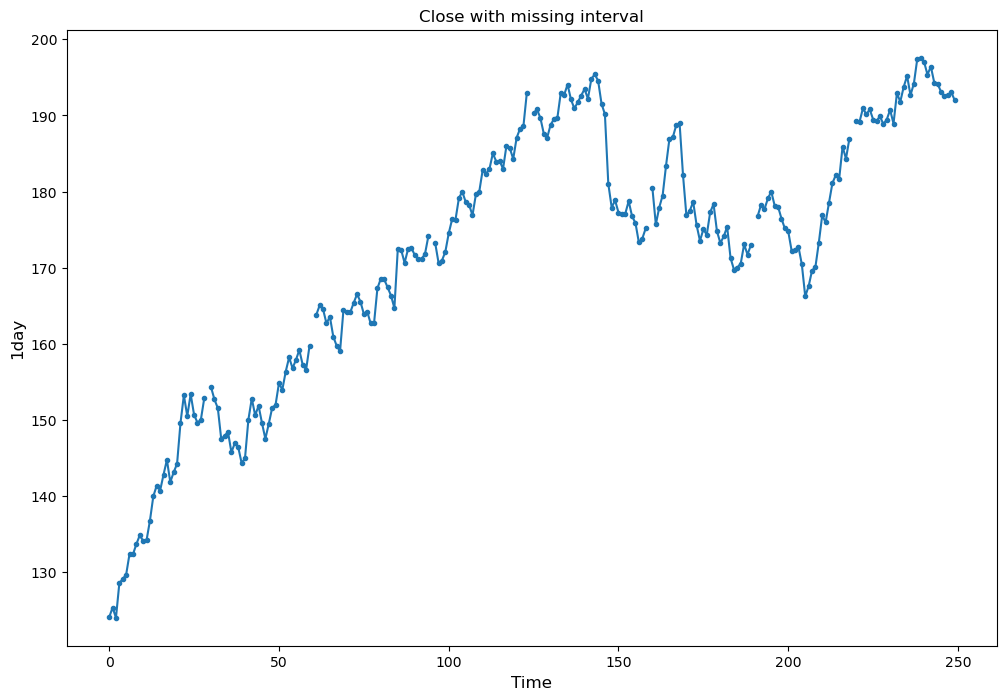

In [4]:
## Plot
# Plot the main line with markers
plt.figure(figsize=(12,8))
plt.plot(df['1day'],'.-')


# Set labels
plt.xlabel('Time', fontsize=12)
plt.ylabel('1day', fontsize=12)
plt.title('Close with missing interval')

plt.show()

Identify missing dates.

In [62]:
imputed_indices = df[df['1day'].isnull()].index

imputed_indices

Index([29, 60, 95, 124, 159, 190, 219], dtype='int64')

## Train Deep Neural Net


In [5]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras import layers

Train the deep neural network on the entire dataset, with the randomly deleted dates. Test the neural net against the missing dates' original values.

In [271]:
features = ['Open','High','Low','Volume']
X_train = df.loc[:, features]
y_train = df.loc[:, ['1day']]

X_test = df.loc[:, features]
y_test = df.loc[:, ['Close']]

Perform a KFold testing split, to randomize the training dataset for the neural network.

In [272]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 973)
for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]



NameError: name 'X' is not defined

Set the parameters of the neural network. This one has three defined hidden layers, with 16, 8, and 4 nodes, respectively.

In [273]:
maxepo=800

dnn_model = tf.keras.Sequential([

  layers.Dense(16, activation='relu'), # first layer

  layers.Dense(8, activation='relu'),  # second layer
  
  layers.Dense(4, activation='relu'),  # third layer

  layers.Dense(1)

])

Compile and run the Deep Neural Network.

In [274]:
dnn_model.compile(

    optimizer=tf.optimizers.Adam(learning_rate=0.01),

    loss='mean_squared_error')

In [275]:
dnn_model.fit(

    X_train, y_train,

    validation_split=0,

    verbose=0, epochs=maxepo)
print(dnn_model.evaluate(X_test, y_test))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan  
nan


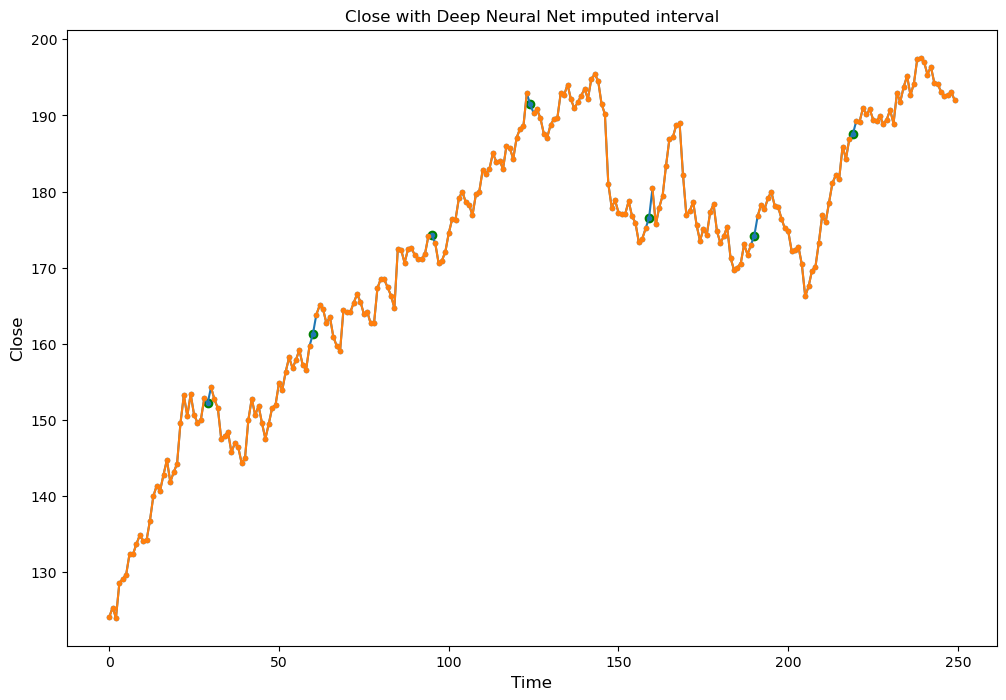

In [276]:
## Plot
# Plot the main line with markers
plt.figure(figsize=(12,8))
plt.plot(y_test['Close'],'.-')
plt.plot(df['1day'],'.-')
# Add points where data was imputed with red color

#plt.figure(figsize=(16,5))
plt.scatter(imputed_indices, df.loc[imputed_indices, '1day'], color='red', label='Imputing data')
plt.scatter(imputed_indices, y_test.loc[imputed_indices, 'Close'], color='green',label='True data')


# Set labels
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.title('Close with Deep Neural Net imputed interval')

plt.show()

The orange lines and nodes are the original dataset with randomly removed dates. The green nodes are the closing values as determined by the Deep Neural Network. The blue lines are the path the Neural Net predicted the closing value, it follows the orange lines perfectly.

The model doesn't deviate from the graph, we suspect an overfit, so we test the MSE

In [277]:
# Given values 
Y_true = [df.loc[imputed_indices, 'Close']]  # Y_true = Y (original values) 
  
# Calculated values 
Y_pred = [y_test.loc[imputed_indices, 'Close']]  # Y_pred = Y' 
  
# Mean Squared Error 
MSE = np.square(np.subtract(Y_true,Y_pred)).mean() 

In [278]:
MSE

0.0

In [279]:
pd.set_option('display.max_rows', None)
Y_pred

[29     152.180191
 60     161.279236
 95     174.234695
 124    191.443298
 159    176.531799
 190    174.220963
 219    187.516052
 Name: Close, dtype: float64]

In [280]:
Y_true

[29     152.180191
 60     161.279236
 95     174.234695
 124    191.443298
 159    176.531799
 190    174.220963
 219    187.516052
 Name: Close, dtype: float64]

As the sample size was very small, the MSE was 0.0, the neural network overfit.